# Random Forest for VM Criticality

Minimal, commented walkthrough to train and evaluate a Random Forest classifier on the VM request table. Assumes the final dataset lives at `data_final/vm_request_table_with_split.parquet` (placed at repo root).

What this notebook covers:
- load data and respect the time-based train/val/test split
- keep only arrival-time + tenant-history features (avoid label leakage)
- simple preprocessing (one-hot for the lone categorical column)
- train a baseline RandomForest with class weighting
- evaluate on val/test (AUC-PR, ROC-AUC, PR/ROC curves, confusion matrix)
- inspect feature importances
- save the fitted pipeline and metrics

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", 120)

DATA_PATH = Path("../data_final/vm_request_table_with_split.parquet")
ARTIFACT_DIR = Path("../models/artifacts")
RANDOM_SEED = 42

assert DATA_PATH.exists(), f"Missing dataset at {DATA_PATH}"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Load the full table once; we'll slice by the time-based split column.
df = pd.read_parquet(DATA_PATH)
print("Data shape:", df.shape)
print("Split counts:\n", df["split"].value_counts())
print("Positive rate (critical=1):", df["critical"].mean().round(4))

Data shape: (894280, 73)
Split counts:
 split
train    632426
test     131849
val      130005
Name: count, dtype: int64
Positive rate (critical=1): 0.3459


In [3]:
# Define which columns are safe to use at VM arrival time (no label leakage).
# These come from README; adjust if preprocessing changes.
TARGET_COL = "critical"
SPLIT_COL = "split"
ID_COLS = ["vm_id", "subscription_id", "deployment_id"]

ARRIVAL_FEATURES = [
    # Identifiers/time (exclude vm_id as a feature)
    "subscription_id",  # can be used for history joins, but we will drop it below to avoid ID leakage
    "deployment_id",    # same note as subscription_id
    "ts_vm_created",
    "day_idx",
    "hour_of_day",
    # Static VM config & deployment metadata
    "vm_category",
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    # Tenant static info
    "ts_first_vm_created",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour",
    # Tenant history features (based only on past VMs)
    "hist_n_vms",
    "hist_n_critical",
    "hist_has_past",
    "hist_critical_frac",
    "hist_lifetime_mean",
    "hist_lifetime_std",
    "hist_cpu_mean_mean",
    "hist_p95_mean",
    "hist_frac_gt60_mean",
    "hist_day_night_ratio_mean",
]

# Columns that must NOT be used for prediction (future behavior / label components / split markers).
POSTHOC_COLS = [
    "ts_vm_deleted",
    "lifetime_sec",
    "lifetime_hours",
    "max_cpu",
    "avg_cpu",
    "p95_max_cpu",
    "n_readings",
    "max_cpu_right",
    "cpu_mean",
    "cpu_std",
    "cpu_frac_gt_60",
    "cpu_frac_gt_80",
    "day_cpu_mean",
    "night_cpu_mean",
    "day_night_ratio",
    # Hourly CPU columns
    *[f"cpu_hour_{h}_mean" for h in range(24)],
    # Label components and split metadata
    "long_lived",
    "sustained_high",
    "strong_diurnal",
    TARGET_COL,
    SPLIT_COL,
]

# Build the final feature list: use arrival features that actually exist, drop raw IDs to avoid leakage.
feature_cols = [c for c in ARRIVAL_FEATURES if c in df.columns and c not in ID_COLS]
missing = sorted(set(ARRIVAL_FEATURES) - set(df.columns))
if missing:
    print("Warning: missing arrival features in dataset:", missing)

print(f"Using {len(feature_cols)} features:")
print(feature_cols)

Using 23 features:
['ts_vm_created', 'day_idx', 'hour_of_day', 'vm_category', 'vm_virtual_core_count', 'vm_memory_gb', 'vm_mem_per_core', 'deployment_size', 'log_deployment_size', 'ts_first_vm_created', 'count_vms_created', 'sub_first_day', 'sub_first_hour', 'hist_n_vms', 'hist_n_critical', 'hist_has_past', 'hist_critical_frac', 'hist_lifetime_mean', 'hist_lifetime_std', 'hist_cpu_mean_mean', 'hist_p95_mean', 'hist_frac_gt60_mean', 'hist_day_night_ratio_mean']


In [4]:
# Split the data.
train_df = df[df[SPLIT_COL] == "train"].copy()
val_df = df[df[SPLIT_COL] == "val"].copy()
test_df = df[df[SPLIT_COL] == "test"].copy()

X_train, y_train = train_df[feature_cols], train_df[TARGET_COL]
X_val, y_val = val_df[feature_cols], val_df[TARGET_COL]
X_test, y_test = test_df[feature_cols], test_df[TARGET_COL]

categorical_cols = [c for c in feature_cols if c == "vm_category"]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print("Train/val/test sizes:", len(X_train), len(X_val), len(X_test))

Train/val/test sizes: 632426 130005 131849


In [5]:
# Preprocessing: one-hot encode vm_category, pass-through numerics.
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop",
)

# Baseline Random Forest; class_weight balances the skewed critical label.
# rf_clf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=None,
#     min_samples_leaf=2,
#     n_jobs=-1,
#     class_weight="balanced",
#     random_state=RANDOM_SEED,
#     verbose=1,  # print tree-building progress so training isn't silent
# )
rf_clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=16,
    min_samples_leaf=2,
    max_features=0.4,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_SEED,
    verbose=1,
)

model = Pipeline([
    ("preprocess", preprocess),
    ("rf", rf_clf),
])

model

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
# Train the model.
model.fit(X_train, y_train)
print("Model trained.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  4.7min


Model trained.


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.3min finished


In [7]:
def evaluate_split(model, X, y, split_name: str, threshold: float = 0.5) -> dict:
    # Compute key metrics and plot confusion + PR/ROC for a split.
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)

    auc_pr = average_precision_score(y, proba)
    auc_roc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, preds)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: not critical", "Actual: critical"],
        columns=["Pred: not critical", "Pred: critical"],
    )

    print(f"[{split_name}] AUC-PR={auc_pr:.4f}, AUC-ROC={auc_roc:.4f}, threshold={threshold}")
    print("Classification report:", classification_report(y, preds, digits=3, zero_division=0))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"PR curve – {split_name}")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[2])
    axes[2].set_title(f"ROC curve – {split_name}")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": auc_pr, "auc_roc": auc_roc, "confusion": cm.tolist()}


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.6s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.4s finished


[val] AUC-PR=0.7137, AUC-ROC=0.8251, threshold=0.4876884422110553
Classification report:               precision    recall  f1-score   support

           0      0.844     0.848     0.846     90628
           1      0.647     0.639     0.643     39377

    accuracy                          0.785    130005
   macro avg      0.745     0.744     0.744    130005
weighted avg      0.784     0.785     0.784    130005



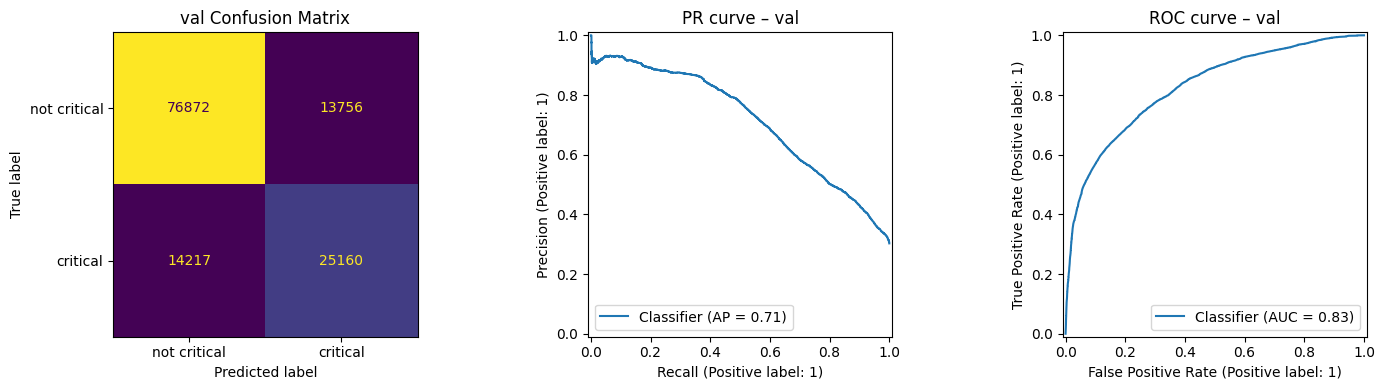

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.4s finished


[test] AUC-PR=0.6867, AUC-ROC=0.7882, threshold=0.4876884422110553
Classification report:               precision    recall  f1-score   support

           0      0.804     0.859     0.831     89173
           1      0.657     0.562     0.606     42676

    accuracy                          0.763    131849
   macro avg      0.730     0.711     0.718    131849
weighted avg      0.756     0.763     0.758    131849



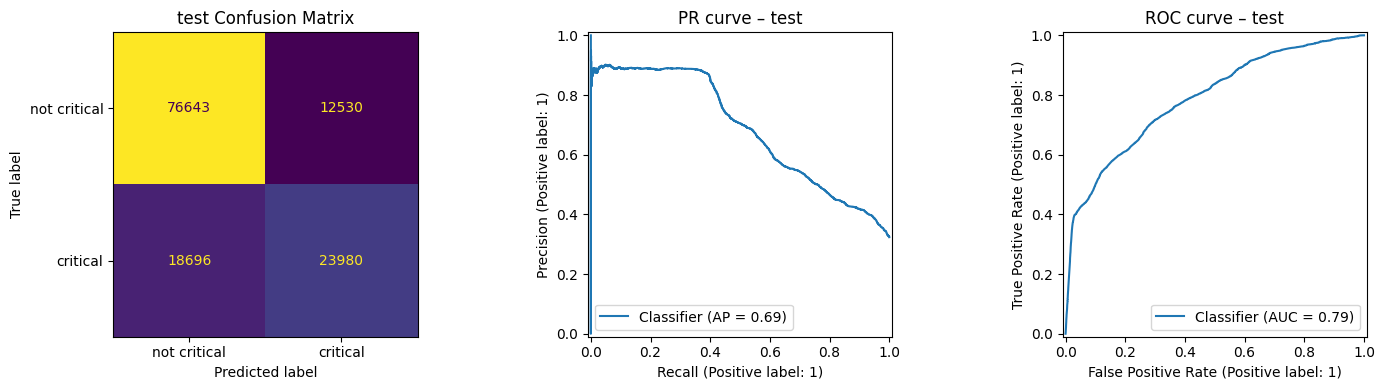

In [8]:
# proba_val = model.predict_proba(X_val)[:,1]
# thresholds = np.linspace(0.01, 0.5, 200)
# best = max(((t, average_precision_score(y_val, (proba_val>=t).astype(int)))
#             for t in thresholds),
#            key=lambda x: x[1])
# best_threshold = best[0]
# metrics_val = evaluate_split(model, X_val, y_val, "val", threshold=best_threshold)
# metrics_test = evaluate_split(model, X_test, y_test, "test", threshold=best_threshold)

from sklearn.metrics import f1_score, precision_recall_curve

proba_val = model.predict_proba(X_val)[:, 1]

candidates = np.linspace(0.01, 0.5, 200)
best_threshold = max(candidates, key=lambda t: f1_score(y_val, (proba_val >= t).astype(int)))

# Optional: get the PR curve arrays too
prec, rec, pr_thresholds = precision_recall_curve(y_val, proba_val)

metrics_val = evaluate_split(model, X_val, y_val, "val", threshold=best_threshold)
metrics_test = evaluate_split(model, X_test, y_test, "test", threshold=best_threshold)


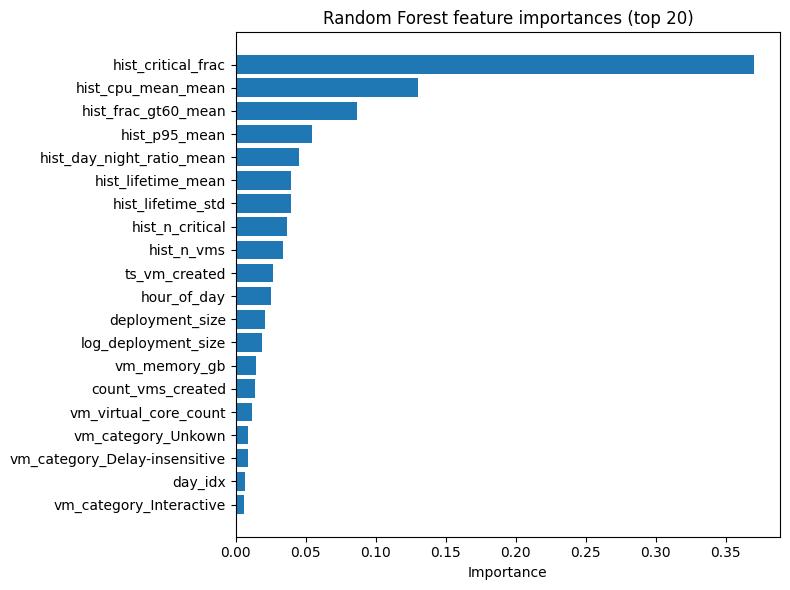

[{'feature': 'hist_critical_frac', 'importance': 0.37029888112554427},
 {'feature': 'hist_cpu_mean_mean', 'importance': 0.12980992010962156},
 {'feature': 'hist_frac_gt60_mean', 'importance': 0.08641196457976577},
 {'feature': 'hist_p95_mean', 'importance': 0.05467923295038421},
 {'feature': 'hist_day_night_ratio_mean', 'importance': 0.045428150384708765},
 {'feature': 'hist_lifetime_mean', 'importance': 0.03964904850118057},
 {'feature': 'hist_lifetime_std', 'importance': 0.03933600550485757},
 {'feature': 'hist_n_critical', 'importance': 0.036322457998679385},
 {'feature': 'hist_n_vms', 'importance': 0.033676626751316156},
 {'feature': 'ts_vm_created', 'importance': 0.026844926140201845},
 {'feature': 'hour_of_day', 'importance': 0.025296050845352854},
 {'feature': 'deployment_size', 'importance': 0.0207659983185498},
 {'feature': 'log_deployment_size', 'importance': 0.019027857541716167},
 {'feature': 'vm_memory_gb', 'importance': 0.014099972955880207},
 {'feature': 'count_vms_creat

In [9]:
# Feature importances: map back to readable feature names (including one-hot columns).
rf = model.named_steps["rf"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]

cat_features = list(ohe.get_feature_names_out(categorical_cols)) if categorical_cols else []
all_features = cat_features + numeric_cols

importances = rf.feature_importances_
top_k = 20
idx = np.argsort(importances)[::-1][:top_k]

plt.figure(figsize=(8, 6))
plt.barh(np.array(all_features)[idx][::-1], importances[idx][::-1])
plt.xlabel("Importance")
plt.title("Random Forest feature importances (top 20)")
plt.tight_layout()
plt.show()

feature_ranking = [
    {"feature": all_features[i], "importance": float(importances[i])}
    for i in idx
]
feature_ranking

In [10]:
# Save the trained pipeline and simple metrics for reuse.
import joblib

model_path = ARTIFACT_DIR / "random_forest_pipeline.joblib"
metrics_path = ARTIFACT_DIR / "random_forest_metrics.json"

joblib.dump(model, model_path)

with metrics_path.open("w") as f:
    json.dump(
        {
            "val": metrics_val,
            "test": metrics_test,
            "params": model.named_steps["rf"].get_params(),
            "features": feature_cols,
            "categorical": categorical_cols,
            "numeric": numeric_cols,
            "random_seed": RANDOM_SEED,
        },
        f,
        indent=2,
    )

print(f"Saved model to {model_path}")
print(f"Saved metrics to {metrics_path}")

Saved model to ..\models\artifacts\random_forest_pipeline.joblib
Saved metrics to ..\models\artifacts\random_forest_metrics.json



STARTING RANDOM FOREST OPTIMIZATION
1. Calculating Baseline Performance...


c:\Users\dpnim\miniconda3\envs\machine_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.4s finished


   Baseline Validation AUC: 0.82506
2. Computing Permutation Importance...


Permuting features:   0%|          | 0/23 [00:00<?, ?it/s][Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.5s finished
Permuting features:   4%|▍         | 1/23 [00:00<00:14,  1.49it/s][Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.4s finished
Permuting features:   9%|▊         | 2/23 [00:01<00:13,  1.60it/s][Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elaps

   > Found 7 non-predictive features (Importance <= 0).
3. Checking for Multicollinearity (>0.95)...
   > Found 3 highly correlated features.

DROPPING 8 FEATURES: ['ts_vm_created', 'sub_first_day', 'hist_n_critical', 'vm_mem_per_core', 'hist_day_night_ratio_mean', 'day_idx', 'hist_has_past', 'hist_n_vms']

Retraining Random Forest with 14 numeric and 1 categorical features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.9min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s


Training Complete.

FINAL OPTIMIZED PERFORMANCE REPORT


[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.5s finished


Selected Threshold: 0.4752
ROC AUC:  0.8132
PR AUC:   0.7423
Max F1:   0.6647
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.8320    0.8703    0.8507     89173
           1     0.7002    0.6327    0.6647     42676

    accuracy                         0.7934    131849
   macro avg     0.7661    0.7515    0.7577    131849
weighted avg     0.7893    0.7934    0.7905    131849



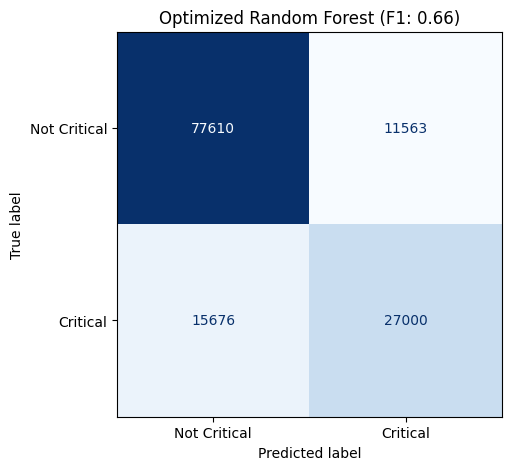


Top 10 Important Features (Optimized):
hist_critical_frac: 0.3507
hist_cpu_mean_mean: 0.1649
hist_frac_gt60_mean: 0.1065
hist_p95_mean: 0.0767
hist_lifetime_mean: 0.0603
hist_lifetime_std: 0.0600
hour_of_day: 0.0365
deployment_size: 0.0312
log_deployment_size: 0.0286
count_vms_created: 0.0226


In [11]:
# ==============================================================================
# AUTOMATED FEATURE SELECTION & RETRAINING BLOCK (RANDOM FOREST)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

print("\n" + "="*50)
print("STARTING RANDOM FOREST OPTIMIZATION")
print("="*50)

# 1. Calculate Baseline Performance
# ------------------------------------------------------------------------------
print("1. Calculating Baseline Performance...")
# Use predict_proba for smooth AUC scoring
base_probas = model.predict_proba(X_val)[:, 1]
base_auc = roc_auc_score(y_val, base_probas)
print(f"   Baseline Validation AUC: {base_auc:.5f}")

# 2. Permutation Feature Importance
# ------------------------------------------------------------------------------
# We shuffle raw features *before* the pipeline to test true importance
# Note: For RF, we can also look at `feature_importances_`, but permutation is more reliable for generalization.
all_features = numeric_cols + categorical_cols
importances = {}

print("2. Computing Permutation Importance...")
for feat in tqdm(all_features, desc="Permuting features", leave=False):
    X_val_perm = X_val.copy()
    X_val_perm[feat] = np.random.permutation(X_val_perm[feat].values)
    
    # Predict with permuted feature
    perm_probas = model.predict_proba(X_val_perm)[:, 1]
    perm_auc = roc_auc_score(y_val, perm_probas)
    
    # Importance = Baseline - Permuted (Positive is good)
    importances[feat] = base_auc - perm_auc

# Identify zero/negative importance features
zero_imp_feats = [k for k, v in importances.items() if v <= 0.0]
print(f"   > Found {len(zero_imp_feats)} non-predictive features (Importance <= 0).")

# 3. Correlation Analysis (Redundancy)
# ------------------------------------------------------------------------------
# Random Forest handles correlation better than Linear Models, but removing redundancy speeds up training.
print("3. Checking for Multicollinearity (>0.95)...")
corr_matrix = X_train[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_feats = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"   > Found {len(high_corr_feats)} highly correlated features.")

# 4. Construct Drop List
# ------------------------------------------------------------------------------
drop_candidates = set(zero_imp_feats + high_corr_feats)

# Safety: Don't drop all features
if len(drop_candidates) == len(all_features):
    print("   ! Warning: Analysis suggested dropping ALL features. Backing off to safe mode.")
    drop_candidates = set(zero_imp_feats)

# Logic: Prefer 'log' versions if correlated
if "deployment_size" in drop_candidates and "log_deployment_size" in drop_candidates:
    drop_candidates.remove("log_deployment_size")

final_drop_list = list(drop_candidates)
print(f"\nDROPPING {len(final_drop_list)} FEATURES: {final_drop_list}")

# 5. Retraining
# ------------------------------------------------------------------------------
# Filter feature lists
OPT_NUM_COLS = [c for c in numeric_cols if c not in final_drop_list]
OPT_CAT_COLS = [c for c in categorical_cols if c not in final_drop_list]

print(f"\nRetraining Random Forest with {len(OPT_NUM_COLS)} numeric and {len(OPT_CAT_COLS)} categorical features...")

# Rebuild Preprocessor with optimized columns
opt_preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, OPT_CAT_COLS),
        ("num", "passthrough", OPT_NUM_COLS),
    ],
    remainder="drop",
)

# Rebuild Pipeline with same RF parameters
opt_model = Pipeline([
    ("preprocess", opt_preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        max_depth=16,
        min_samples_leaf=2,
        max_features=0.4,
        n_jobs=-1,
        class_weight="balanced",
        random_state=RANDOM_SEED,
        verbose=1,
    )),
])

# Fit
opt_model.fit(X_train, y_train)
print("Training Complete.")

# 6. Final Evaluation
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("FINAL OPTIMIZED PERFORMANCE REPORT")
print("="*50)

# Get probabilities
test_probas = opt_model.predict_proba(X_test)[:, 1]

# Metrics
roc_auc = roc_auc_score(y_test, test_probas)
pr_auc = average_precision_score(y_test, test_probas)

# Find Optimal Threshold (Maximize F1)
precisions, recalls, thresholds = precision_recall_curve(y_test, test_probas)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Hard predictions
final_preds = (test_probas >= best_thresh).astype(int)

print(f"Selected Threshold: {best_thresh:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")
print(f"PR AUC:   {pr_auc:.4f}")
print(f"Max F1:   {best_f1:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, final_preds, digits=4))

# Visuals
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Critical", "Critical"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f"Optimized Random Forest (F1: {best_f1:.2f})")
plt.show()

# Show Top Feature Importances of Optimized Model
try:
    rf_opt = opt_model.named_steps["rf"]
    ohe_opt = opt_model.named_steps["preprocess"].named_transformers_["cat"]
    
    # Handle case where cat columns might have been dropped entirely
    if len(OPT_CAT_COLS) > 0:
        opt_cat_features = list(ohe_opt.get_feature_names_out(OPT_CAT_COLS))
    else:
        opt_cat_features = []
        
    opt_all_features = opt_cat_features + OPT_NUM_COLS
    
    importances = rf_opt.feature_importances_
    idx = np.argsort(importances)[::-1][:10]
    
    print("\nTop 10 Important Features (Optimized):")
    for i in idx:
        print(f"{opt_all_features[i]}: {importances[i]:.4f}")
        
except Exception as e:
    print(f"\nCould not extract feature importances: {e}")